In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

SUBSET_LEN = 11
DPI = 80
FIGSIZE, FIGSIZE_LONG = (10, 6), (12, 6)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('axes', labelsize=20)

In [2]:
wind_df = pd.read_csv("wind_cropped.csv", index_col=0)
sea_df = pd.read_csv("sea_cropped.csv", index_col=0)

In [3]:
coordinates = wind_df.index
dates = wind_df.columns

In [31]:
# в этой части мы исследуем количество штормовых и спокойных дней в каждой точке, которая попала в выборку
storm_wind_speed = 10 # 10 / 1.5, 10, 10 * 1.5
storms = []
for i in range(len(coordinates)):
    index = coordinates[i]
    
    j = 0
    while j + SUBSET_LEN < len(dates):
        if wind_df.iloc[i, j] < storm_wind_speed: # нет шторма
            j += 1
        else: # шторм, смотрим
            count_storm, count_calm = 0, 0
            for shift in range(SUBSET_LEN):
                if not np.isnan(sea_df.iloc[i, j + shift]):
                    count_storm += (wind_df.iloc[i, j + shift] >= storm_wind_speed)
                    count_calm += (wind_df.iloc[i, j + shift] < storm_wind_speed)
            
            if count_storm >= 4 and count_calm >= 4 and count_storm + count_calm == SUBSET_LEN:
                storms.append([count_storm, count_calm, i, j]) # начало шторма
            j += SUBSET_LEN
print(len(storms))

472387


In [32]:
# создаем более удобный датафрейм, который для каждой точки из выборки сохраняет информацию о ней
N_subsets = len(storms)
source_rows_list = []
for index in range(N_subsets):
    i, j = storms[index][2], storms[index][3]
    count_storm = storms[index][0] # количество штормовых дней
    count_calm = storms[index][1] # количество спокойных дней
    storm_coordinates = wind_df.index[i] # координаты шторма
    storm_date = wind_df.columns[j] # дата начала шторма
    
    storm_sea, calm_sea = [], []
    for shift in range(SUBSET_LEN):
        cur_sla = sea_df.iloc[i, j + shift]
        cur_wind = wind_df.iloc[i, j + shift]
        if cur_wind >= storm_wind_speed:
            storm_sea.append(cur_sla)
        else:
            calm_sea.append(cur_sla)
    
    mean_storm_sla = np.mean(storm_sea)
    mean_calm_sla = np.mean(calm_sea)
    row_df = [storm_date, storm_coordinates, count_storm, count_calm, 
              mean_storm_sla, mean_calm_sla, mean_storm_sla - mean_calm_sla]
    source_rows_list.append(row_df)

source_subsets_df = pd.DataFrame(source_rows_list, 
        columns=["start_date", "coordinates", "count_storm", "count_calm", "sla_storm", "sla_calm", "sla_diff"])
sla_diff = source_subsets_df.sla_diff.to_numpy()

In [33]:
source_subsets_df

,start_date,coordinates,count_storm,count_calm,sla_storm,sla_calm,sla_diff
0,1993-10-02,"(11.25, 79.04348)",4,7,0.048904,0.035181,0.013723
1,1997-11-25,"(11.25, 79.04348)",4,7,0.031582,0.034361,-0.002778
2,1998-02-13,"(11.25, 79.04348)",5,6,-0.036019,-0.043543,0.007524
3,1992-12-31,"(22.5, 79.04348)",4,7,-0.007471,-0.019372,0.011901
4,1993-10-02,"(22.5, 79.04348)",4,7,0.037068,0.036177,0.000891
...,...,...,...,...,...,...,...
472382,2012-02-10,"(191.25, -77.13935)",4,7,0.083333,0.083618,-0.000284
472383,2018-02-08,"(191.25, -77.13935)",4,7,-0.024085,-0.018333,-0.005752
472384,2018-02-08,"(193.125, -77.13935)",4,7,-0.015193,-0.006049,-0.009144
472385,2018-02-08,"(195.0, -77.13935)",4,7,-0.003288,0.007011,-0.010299


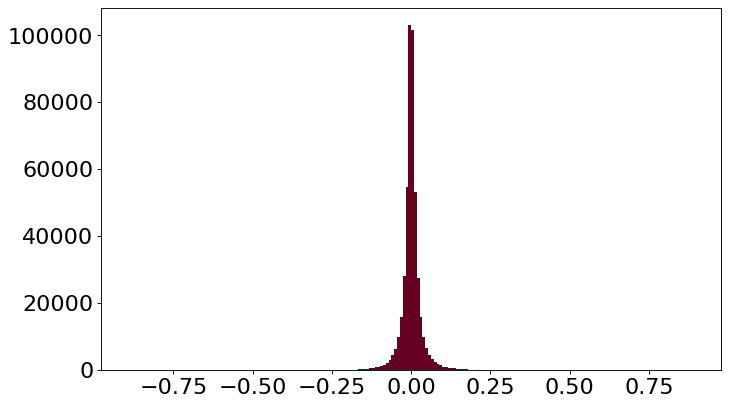

In [34]:
fig = plt.figure(dpi=DPI, figsize=FIGSIZE)
abs_max = abs(sla_diff).max()
(y, bins, batches) = plt.hist(sla_diff, bins=200, range=(-abs_max, abs_max), color="xkcd:maroon")
x = np.array([(bins[i + 1] + bins[i]) / 2 for i in range(len(bins) - 1)])

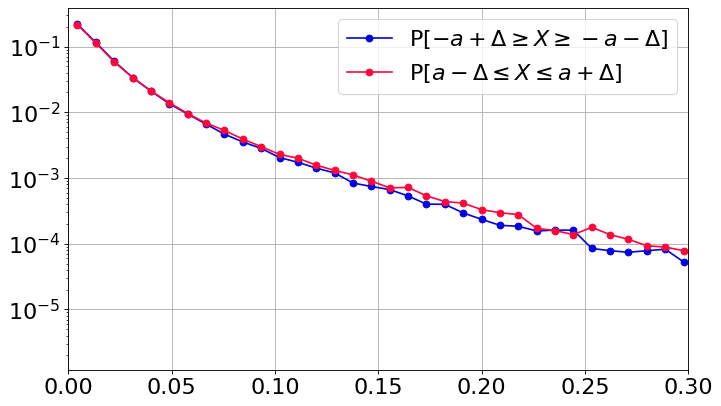

In [35]:
# Рисуем распределение точек для точек на отрезке [0; 0.3]
# График почти повторяет тот, что получен для исходной выборки
# Дельта в данном случае равно 1/bins (см блок выше)
fig = plt.figure(dpi=DPI, figsize=FIGSIZE)
plt.grid(True)
plt.yscale('log')
plt.plot(-x[x < 0], y[x < 0] / len(sla_diff), '-o', 
         color="xkcd:pure blue", label="P[$-a + \Delta \geq X \geq -a - \Delta$]")
plt.plot(x[x >= 0], y[x >= 0] / len(sla_diff), '-o', 
         color="xkcd:neon red", label="P[$a - \Delta \leq X \leq a + \Delta$]")
plt.xlim((0.0, 0.3))
plt.legend(loc="best")
plt.show()
fig.savefig("sla_log_hist_{}.pdf".format(storm_wind_speed))

А теперь сгенерируем некоторую случайную выборку значений $P[X \geq a] - P[X \leq -a]$, чтобы понять, является ли найденное значение статистически значимым или нет.

In [36]:
fraq_4_7 = len(source_subsets_df[(source_subsets_df.count_storm == 4) & (source_subsets_df.count_calm == 7)])
fraq_5_6 = len(source_subsets_df[(source_subsets_df.count_storm == 5) & (source_subsets_df.count_calm == 6)])
fraq_6_5 = len(source_subsets_df[(source_subsets_df.count_storm == 6) & (source_subsets_df.count_calm == 5)])
fraq_7_4 = len(source_subsets_df[(source_subsets_df.count_storm == 7) & (source_subsets_df.count_calm == 4)])

p1 = fraq_4_7 / N_subsets # вероятность распределение дней как (4, 7)
p2 = fraq_5_6 / N_subsets # вероятность распределение дней как (5, 6)
p3 = fraq_6_5 / N_subsets # вероятность распределение дней как (6, 5)
p4 = fraq_7_4 / N_subsets # вероятность распределение дней как (7, 4)

storm_days_cnt = np.array([4, 5, 6, 7])
storm_days_proba = np.array([p1, p2, p3, p4]) 

print(storm_wind_speed, fraq_4_7, fraq_5_6, fraq_6_5, fraq_7_4, N_subsets)
(fraq_4_7 + fraq_5_6 + fraq_6_5 + fraq_7_4) == N_subsets

10 134188 126240 115384 96575 472387


True

In [13]:
def getRandomSubsetsDataframe(coordinates, dates, shift_days=6, shift_coordinates=0):
    random_rows_list = []
    for index in range(N_subsets):
        if index % 50000 == 0:
            print(index)
        i, j = storms[index][2], storms[index][3]
        if i + shift_coordinates >= len(coordinates) or j + shift_days + SUBSET_LEN > len(dates):
            continue
        k = 0
        while k < SUBSET_LEN and not np.isnan(sea_df.iloc[i + shift_coordinates, j + shift_days + k]):
            k += 1
        if k < SUBSET_LEN:
            continue
            
        random_rows_list.append([i + shift_coordinates, j + shift_days])
    return pd.DataFrame(random_rows_list, columns=["coordinates_index", "start_date_index"])

random_subsets_df = getRandomSubsetsDataframe(coordinates, dates)

0
50000


In [14]:
def getMeanSlaDifference(index):
    i, j = random_subsets_df.iloc[index, 0], random_subsets_df.iloc[index, 1] # уже сдвинуты
    count_storm = random.choices(storm_days_cnt, storm_days_proba)[0] # count_calm = 11 - count_storm 

    random_storms = np.random.choice(np.arange(subset_len), count_storm, replace=False)
    random_storms_indexes = np.zeros(SUBSET_LEN, dtype=bool)
    random_storms_indexes[random_storms] = True

    mean_storm_sla = sea_df.iloc[i, j:j + subset_len][random_storms_indexes].mean()
    mean_calm_sla = sea_df.iloc[i, j:j + subset_len][~random_storms_indexes].mean()
    return mean_storm_sla - mean_calm_sla

meanSlaDiff = np.vectorize(getMeanSlaDifference)

In [15]:
def getProbabilityDifference(values, a_array): # P[X >= a] - P[X <= -a]
    return np.array([((values >= a).sum() - (values <= -a).sum()) / values.size for a in a_array])

def getExpectationDifference(values, cur_a, delta): # P[a < X < a + delta] - P[-a - delta < X < -a]
    p_plus_a = ((values >= cur_a) & (values <= cur_a + delta)).sum() / values.size
    p_minus_a =((values >= -cur_a - delta) & (values <= -cur_a)).sum() / values.size
    return p_plus_a - p_minus_a

def findExpectation(values, a): # sum_{a} a_i \cdot \Delta p(a)
    expectation = 0.0
    for i in range(len(a) - 1):
        expectation += a[i] * getExpectationDifference(values, a[i], a[i + 1] - a[i])
    return expectation

In [18]:
from concurrent.futures import ProcessPoolExecutor

tests_number = 1000
random_sla_diff = []
def test(i):
    cur_sla_diff = meanSlaDiff(random_subsets_df.index)
    return (i, cur_sla_diff)

futures = []
with ProcessPoolExecutor(max_workers=10) as executor:
    futures = executor.map(test, range(tests_number))

    for x in futures:
        print(x[0])
        random_sla_diff.append(x[1]) # sla_diff для i-го теста

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [19]:
random_sla_file = open("random_sla_diff_{}.txt".format(storm_wind_speed), "w")
for i in range(tests_number):
    print(" ".join(map(str, random_sla_diff[i])), file=random_sla_file)
random_sla_file.close()
random_sla_diff = np.array(random_sla_diff) # shape  = (tests_number, N_subsets)

In [16]:
tests_number = 1000
random_sla_file = open("random_sla_diff_{}.txt".format(storm_wind_speed), "r")
random_sla_diff = []
for line in random_sla_file:
    random_sla_diff.append(list(map(float, line.split())))
    if len(random_sla_diff) % 100 == 0:
        print(len(random_sla_diff))
random_sla_file.close()
random_sla_diff = np.array(random_sla_diff) # shape = (tests_number, N_subsets)

100
200
300
400
500
600
700
800
900
1000


In [17]:
start_a = dict({6.7: 0.05, 10: 0.015, 15: 0.0}) # [start_a, 0.5] с шагом 0.005
a = np.arange(start_a[storm_wind_speed], 0.5001, 0.005)

In [18]:
random_expectations = []
for i in range(tests_number):
    random_expectations.append(findExpectation(random_sla_diff[i], a))

In [19]:
random_proba_difference = []
for i in range(tests_number):
    random_proba_difference.append(getProbabilityDifference(random_sla_diff[i], a))
random_proba_difference = np.array(random_proba_difference) # shape = (tests_number, a.size)

In [20]:
need_percentile = 99
need_index = 990
random_proba_endvalues = [np.percentile(random_proba_difference[:,i], need_percentile) for i in range(len(a))]
real_proba_difference = getProbabilityDifference(sla_diff, a)
test = random_expectations.index(sorted(random_expectations)[need_index])

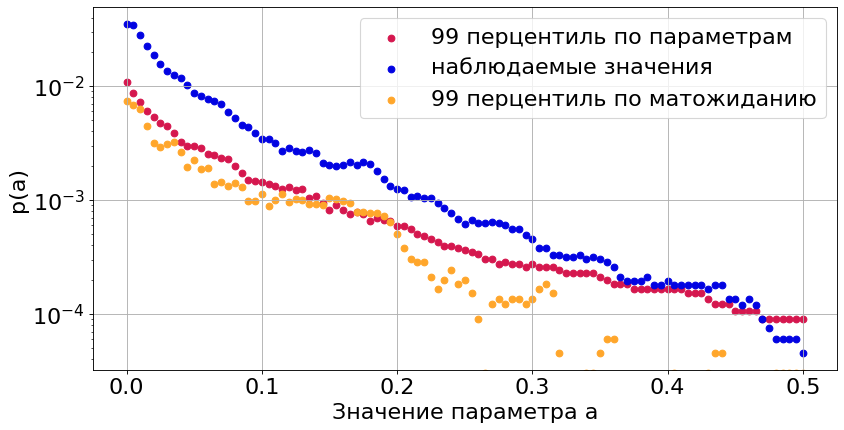

In [21]:
fig = plt.figure(dpi=DPI, figsize=FIGSIZE_LONG)
plt.xlabel("Значение параметра a")
plt.ylabel("p(a)")
plt.scatter(a, random_proba_endvalues, color="xkcd:lipstick", label="99 перцентиль по параметрам")
plt.scatter(a, real_proba_difference, color="xkcd:pure blue", label="наблюдаемые значения")
plt.scatter(a, random_proba_difference[test], color="xkcd:mango", label="99 перцентиль по матожиданию")
plt.grid(True)
plt.yscale("log")
plt.legend(loc="best")
plt.show()
fig.savefig("random_tests_log_{}.pdf".format(storm_wind_speed))

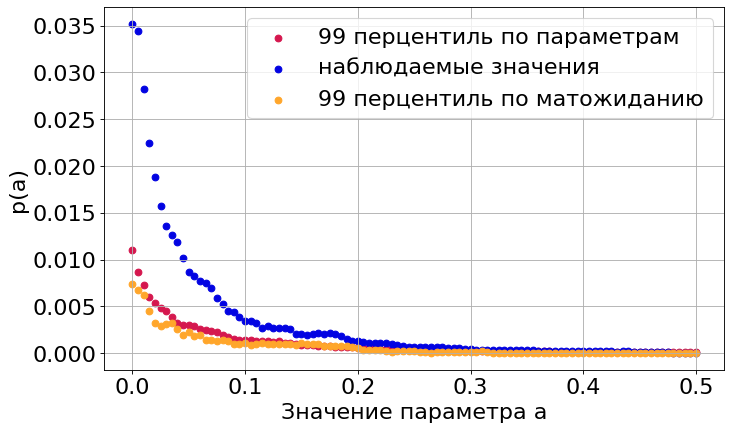

In [22]:
fig = plt.figure(dpi=DPI, figsize=FIGSIZE)
plt.xlabel("Значение параметра a")
plt.ylabel("p(a)")
plt.scatter(a, random_proba_endvalues, color="xkcd:lipstick", label="99 перцентиль по параметрам")
plt.scatter(a, real_proba_difference, color="xkcd:pure blue", label="наблюдаемые значения")
plt.scatter(a, random_proba_difference[test], color="xkcd:mango", label="99 перцентиль по матожиданию")
plt.grid(True)
plt.legend(loc="best")
plt.show()
fig.savefig("random_tests_{}.pdf".format(storm_wind_speed))